<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/Session3and4/group8_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 & 4
In the last session, you learned the basic processing steps for RNA sequencing data. Now you will do the next steps in the analysis of transcriptomics data to investigate the transcriptional impact of TBX5 on human cardiomyocyte differentiation.

### Background
Human induced pluripotent stem cell-derived cardiomyocytes (hiPSC-CMs) are widely used for disease modeling and therapeutic testing, but their immaturity and heterogeneity remain major limitations. Previous studies have shown that distinct single-cell populations emerge during differentiation, characterized by unique transcriptional regulators. Experimental perturbations in hiPSC-CMs have revealed that TBX5 gain- or loss-of-function reshapes gene networks.

In this practical, you will compare the effect of TBX5 gain-of-function (overexpression: tbx-oe) with TBX5 loss-of-function (CRISPR genome editing: tbx-ge).

### Objectives  
1. Explore global gene expression changes (PCA) across TBX5 conditions.
2. Identify differentially expressed genes (DEGs) specific to TBX5 perturbations.  
3. Visualize DEGs with volcano plots and heatmaps.  
4. Perform GO enrichment to determine affected biological pathways.  
5. Interpret whether downregulation of TBX5 leads to loss of cardiomyocyte identity and/or gain of non-cardiac programs.  

## Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.

In [1]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy

In [2]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
group_number = 8

In [4]:
#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

#Download datasets in the data folder
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group{group_number}_counts.txt -O data/group{group_number}_counts.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group{group_number}_metadata.csv -O data/group{group_number}_metadata.csv

--2025-12-02 11:58:15--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group8_counts.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1004650 (981K) [text/plain]
Saving to: ‘data/group8_counts.txt’

data/group8_counts. 100%[===================>] 981.10K  --.-KB/s    in 0.03s   

2025-12-02 11:58:16 (29.2 MB/s) - ‘data/group8_counts.txt’ saved [1004650/1004650]

--2025-12-02 11:58:16--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group8_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.c

## Data import
Read the count matrix.
- How many samples and genes do you have?

<details>
<summary>💡 Show solution</summary>
    
There are 4 samples (2 wildtype, 2 mutant) and 42833 genes.

Read the corresponding metadata table.
- Which differentiation day do the samples belong to?

<details>
<summary>💡 Show solution</summary>
    
The samples belong to differentiation day 7.

### ANSWER CODE

In [5]:
# Load data
counts = pd.read_csv("data/group8_counts.txt", sep="\t", index_col=0)
metadata = pd.read_csv("data/group8_metadata.csv")
metadata.index=metadata['sample_id']
print(counts)
metadata

             day30_rep3_tbx5_ge  day30_rep1_tbx5_ge  day30_rep2_tbx5_ge  \
DDX11L1                       0                   1                   1   
WASH7P                      374                 304                 356   
MIR6859-1                     4                   4                   2   
MIR1302-2HG                   0                   0                   0   
MIR1302-2                     0                   0                   0   
...                         ...                 ...                 ...   
ND6                        4372               14143                7799   
TRNE                          0                   0                   0   
CYTB                      16652               38901               27095   
TRNT                          0                   0                   0   
TRNP                        242                 840                 209   

             day30_rep1_tbx5_oe  day30_rep2_tbx5_oe  
DDX11L1                       0              

,sample_id,day,replicate,stage,cell line,condition
sample_id,,,,,,
day30_rep3_tbx5_ge,day30_rep3_tbx5_ge,30.0,3,cardiomyocyte,hiPSC,tbx5_ge
day30_rep1_tbx5_ge,day30_rep1_tbx5_ge,30.0,1,cardiomyocyte,hiPSC,tbx5_ge
day30_rep2_tbx5_ge,day30_rep2_tbx5_ge,30.0,2,cardiomyocyte,hiPSC,tbx5_ge
day30_rep1_tbx5_oe,day30_rep1_tbx5_oe,30.0,1,cardiomyocyte,hiPSC,tbx5_oe
day30_rep2_tbx5_oe,day30_rep2_tbx5_oe,30.0,2,cardiomyocyte,hiPSC,tbx5_oe


## Filtering
Filter the data to remove genes with less than 10 reads over all samples.
- How many genes are left in the count table after filtering?

<details>
<summary>💡 Show solution</summary>
    
There are 21074 genes left after filtering.

### ANSWER CODE

In [6]:
counts = counts[counts.sum(axis=1) >= 10]
print(counts)

              day30_rep3_tbx5_ge  day30_rep1_tbx5_ge  day30_rep2_tbx5_ge  \
WASH7P                       374                 304                 356   
MIR6859-1                      4                   4                   2   
LOC124900384                   5                   1                   2   
LOC729737                    180                 107                 114   
LOC100996442                 162                 142                 156   
...                          ...                 ...                 ...   
ND4                        29764               79930               52491   
ND5                        16186               44743               29391   
ND6                         4372               14143                7799   
CYTB                       16652               38901               27095   
TRNP                         242                 840                 209   

              day30_rep1_tbx5_oe  day30_rep2_tbx5_oe  
WASH7P                       484

## Normalization: counts per million
Perform normalization to account for differences in sequencing depth among samples.

### ANSWER CODE

In [7]:
total_reads = counts.sum(axis = 0)
normalized_count_table = (counts / total_reads) * 1e6
log_transformed_counts = np.log2(normalized_count_table + 1)

## Principle component analysis (PCA)

Now explore your data with PCA like you did in the previous session. Plot the first two principal components, use the seaborn package.
- Does the down- or upregulation have any effect on gene expression or do all samples cluster together?

<details>
<summary>💡 Show solution</summary>
    
The samples cluster separately, but there are also quite some differences between samples from the same condition. Therefore, we cannot yet tell if we will find meaningful differences between the conditions.

### ANSWER CODE

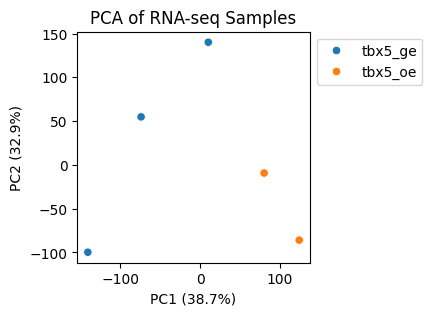

In [8]:
scaler = StandardScaler()
scaled_table = scaler.fit_transform(log_transformed_counts.T)
pca = PCA()
pca_result_matrix = pca.fit_transform(scaled_table)
np.shape(pca_result_matrix)

plot_df = pd.DataFrame({
 "PC1": pca_result_matrix[:, 0],
 "PC2": pca_result_matrix[:, 1],
 "condition": metadata["condition"].values
})

plt.figure(figsize=(3, 3))

sns.scatterplot(
data=plot_df,
x="PC1", y="PC2",
hue="condition"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Differential gene expression

Now you can perform differential gene expression analysis using the DEseq2 method. This method allows to find genes with significant expression differences (up- or downregulated) between two conditions.
- Your goal is to investigate the effect of the perturbation on cardiomyocyte differentiation. Which samples do you need to compare?
- Build your DEseq object(s) and run the analysis. *Make sure you use the raw filtered counts for this (not the counts per million normalized counts used for PCA), since DEseq does it's own internal normalization method.*
- Look at the results of you analysis. What information do the rows and columns of the DEseq result mean?

<details>
<summary>💡 Show solution</summary>
    
We need to compare the missense mutation with the isogenic wildtype. The rows are the gene names and the columns show the statistical differential expression results.
- baseMean: mean normalized expression across all samples.
- log2FoldChange: log₂ of the estimated fold change between conditions.
- lfcSE: standard error of the log2FoldChange estimate.
- stat: Wald test statistic (log2FoldChange / lfcSE).
- pvalue: p-value for H₀: log2FoldChange = 0.
- padj: p-value adjusted for multiple testing (FDR, e.g. Benjamini–Hochberg).

### ANSWER CODE

In [9]:
dds = DeseqDataSet(counts=counts.T, metadata= metadata, design_factors="condition")
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=("condition","tbx5_ge","tbx5_oe")
)
stat_res.summary()
res_df = stat_res.results_df

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.07 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 34.67 seconds.

Fitting LFCs...
... done in 20.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 8.93 seconds.



Log2 fold change & Wald test p-value: condition tbx5_ge vs tbx5_oe
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P          390.674094       -0.082810  0.444419 -0.186333  0.852183   
MIR6859-1         2.755322        1.566112  1.682758  0.930682  0.352018   
LOC124900384      5.567731       -1.816606  1.268706 -1.431857  0.152185   
LOC729737       119.328604        0.846361  0.517924  1.634142  0.102229   
LOC100996442    161.362500        0.209685  0.496491  0.422335  0.672781   
...                    ...             ...       ...       ...       ...   
ND4           74918.852911       -0.502638  0.669833 -0.750393  0.453018   
ND5           46651.036421       -0.813615  0.676719 -1.202294  0.229249   
ND6           13715.706560       -0.809547  0.716098 -1.130498  0.258266   
CYTB          38889.889916       -0.578149  0.637510 -0.906887  0.364467   
TRNP            954.822302       -1.597130  0.821211 -1.944848  0.051793   

                  pa

- Now get the significantly upregulated and downregulated genes from this dataframe with a log2 fold change bigger than 2. Are there more genes that are upregulated or downregulated? _Tip: to get an overview in one figure, you can plot the upregulated and downregulated genes in a volcano plot._

<details>
<summary>💡 Show solution</summary>

There are more genes upregulated (166) than downregulated (89).

### ANSWER CODE

In [10]:
upregulated_genes = res_df[(res_df["log2FoldChange"] > 2) & (res_df["padj"] < 0.05)]
upregulated_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
LOC100132287,11.111641,3.376680,1.133515,2.978947,2.892408e-03,4.917358e-02
ERRFI1,4787.832879,2.696793,0.769817,3.503160,4.597731e-04,1.406725e-02
GPR157,309.357867,2.057821,0.669175,3.075162,2.103880e-03,3.987956e-02
FBXO2,1818.471109,3.637351,0.739654,4.917636,8.759543e-07,1.133448e-04
SH3BGRL3,3338.772626,3.122187,0.647306,4.823354,1.411644e-06,1.696979e-04
...,...,...,...,...,...,...
TXLNGY,424.252649,12.144568,2.431709,4.994252,5.906421e-07,8.152174e-05
KDM5D,1117.930186,12.102966,1.536110,7.878970,3.300912e-15,4.083171e-12
EIF1AY,677.493397,12.820256,2.435880,5.263090,1.416543e-07,2.443929e-05
LOC105377225,36.814140,8.616341,2.599923,3.314075,9.194668e-04,2.278248e-02


In [11]:
downregulated_genes = res_df[(res_df["log2FoldChange"] < -2) & (res_df["padj"] < 0.05)]
downregulated_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
LINC01770,30.813600,-4.060017,0.887812,-4.573060,0.000005,0.000426
LOC107985729,14.463929,-4.180169,1.079231,-3.873286,0.000107,0.004961
HES5,21.046378,-7.033058,1.937589,-3.629799,0.000284,0.010046
LOC124903827,232.726577,-4.043981,0.846197,-4.779008,0.000002,0.000198
PRDM16,530.404785,-3.279256,0.787472,-4.164281,0.000031,0.001864
...,...,...,...,...,...,...
DCX,264.654836,-4.522616,1.277271,-3.540842,0.000399,0.012791
KLHL13,1160.822880,-4.197256,0.875319,-4.795116,0.000002,0.000187
ATP1B4,15.088244,-4.313170,1.316299,-3.276741,0.001050,0.024830
CCDC160,85.971854,-2.717516,0.645460,-4.210203,0.000026,0.001587


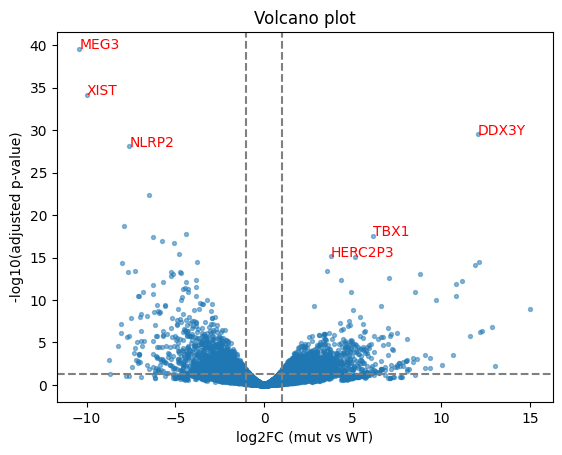

In [12]:
plt.scatter(res_df.log2FoldChange, -np.log10(res_df.pvalue), s=8, alpha=0.5)

plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")

plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(adjusted p-value)")
plt.title(f"Volcano plot")

up = res_df[res_df.log2FoldChange > 1].nsmallest(3, "pvalue")
down = res_df[res_df.log2FoldChange < -1].nsmallest(3, "pvalue")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.pvalue), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.pvalue), gene,
  fontsize=10, color="red")

plt.show()

- Take the dataframe of your DESeq2 results (res_df) and sort the values by the significant p-adjusted value (padj). Then take the top 10 genes names from the sorted dataframe (_hint: top10 = res_df.head(10).index_). What are the top 3 gene names?

<details>
<summary>💡 Show solution</summary>
    
The top 3 differentially expressed genes are MEG3, XIST and DDX3Y.

In [13]:
res_df = res_df.sort_values('padj')
top10 = res_df.head(10).index
top10

Index(['MEG3', 'XIST', 'DDX3Y', 'NLRP2', 'SLC27A6', 'NRAP', 'NPPA', 'TBX1',
       'PAX8-AS1', 'USP6'],
      dtype='object')

- Now plot the top 10 differentially expressed genes. Can you confirm whether the authors managed to succesfully knockdown or overexpress our gene of interest?
<details>
<summary>💡 Show solution</summary>

Yes, you can see a higher expression of TBX5 in the overexpressed samples compared to the gene-edited samples, so the overexpression worked. However, they did not manage to fully knockout TBX5 with gene-editing.

### ANSWER CODE

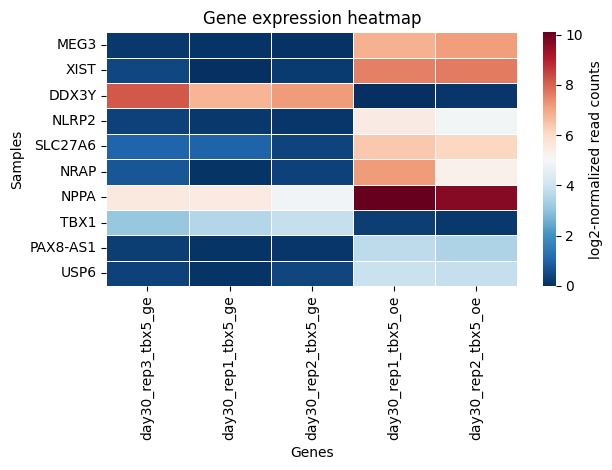

In [14]:
sns.heatmap(
log_transformed_counts.loc[top10],
cmap="RdBu_r",
linecolor = "white",
linewidth = 0.5,
cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Gene expression heatmap")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

# Gene Ontology enrichment

Now, you can start interpreting the lists of genes you get from the DEseq analysis and learn if there are any biological pathways that are affected by the TBX5 perturbation.
- Use the cheat sheet to perform a GO enrichment analysis on the upregulated and downregulated genes. Which biological processes are downregulated in gene-edited vs overexpressed samples at this day?
- Can you find scientific evidence in literature that these processes are regulated by TBX5?

<details>
<summary>💡 Show solution</summary>

Biological processes that are downregulated are mostly related to cardiac conduction, in which TBX5 plays an important role. TBX5 is essential for cardiac septation, conduction system development, and chamber specification. Experimental perturbations in hiPSC-CMs have revealed that TBX5 gain- or loss-of-function reshapes gene networks controlling cardiac conduction and atrial fate.  

- https://doi.org/10.1016/bs.ctdb.2016.08.008

### ANSWER CODE

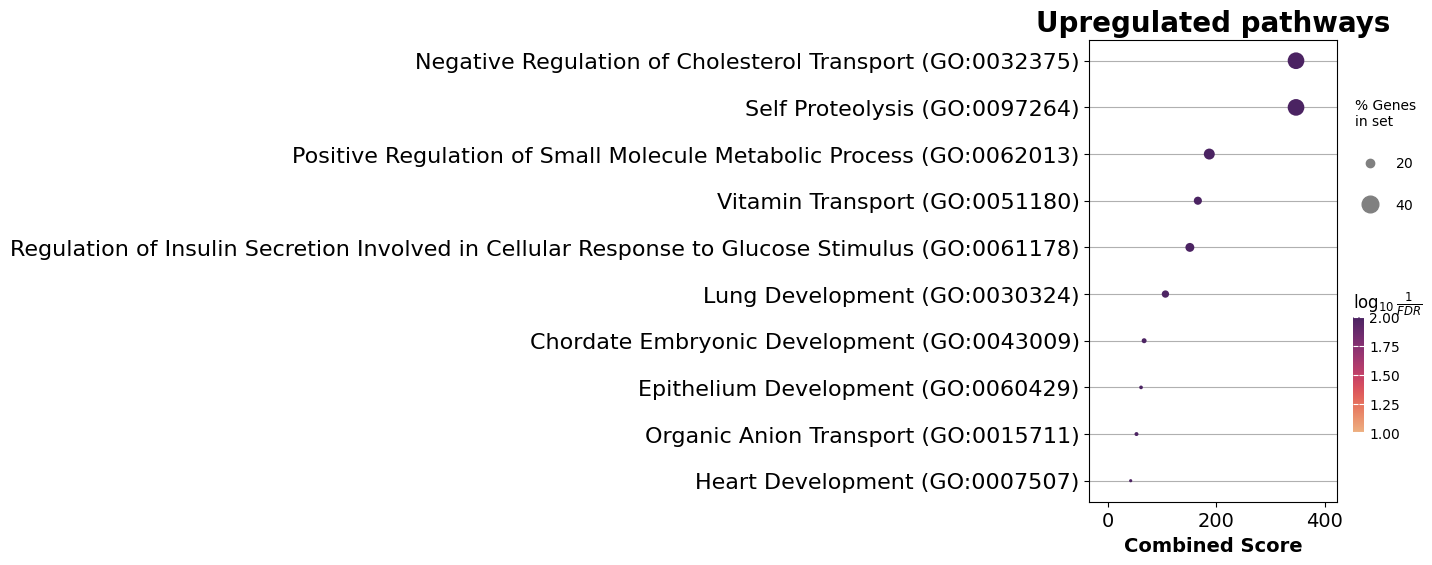

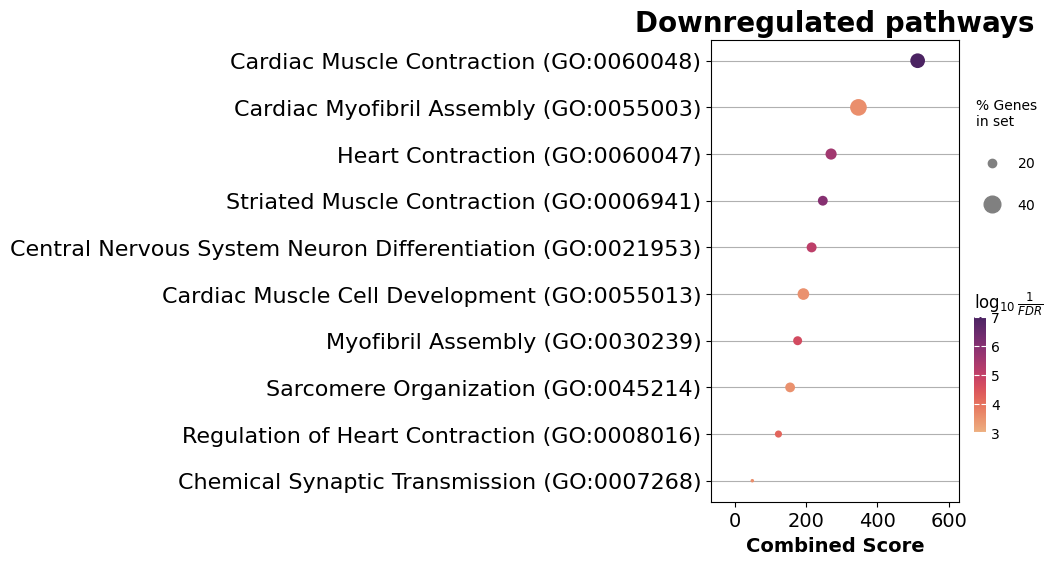

In [18]:
up   = upregulated_genes.index.tolist()
down = downregulated_genes.index.tolist()

enr_up = gseapy.enrichr(up,
                        gene_sets=["GO_Biological_Process_2025"],
                        organism="Human", cutoff=0.05)
gseapy.plot.dotplot(enr_up.res2d, title=f"Upregulated pathways", cmap="flare", top_term=10)
plt.show()

enr_down = gseapy.enrichr(down,
                          gene_sets=["GO_Biological_Process_2025"],
                          organism="Human", cutoff=0.05)
gseapy.plot.dotplot(enr_down.res2d, title=f"Downregulated pathways", cmap="flare", top_term=10)
plt.show()